In [ ]:
print("Test")

In [1]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: d:\Data\Projects\llm-research-genie


In [2]:
from research_and_analyst.utils.model_loader import ModelLoader
model_loader = ModelLoader()
llm = model_loader.load_llm()

{"timestamp": "2025-10-16T23:29:22.359736Z", "level": "info", "event": "OPENAI_API_KEY loaded from environment"}
{"timestamp": "2025-10-16T23:29:22.359736Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-10-16T23:29:22.359736Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-10-16T23:29:22.359736Z", "level": "info", "event": "ASTRA_DB_API_ENDPOINT loaded from environment"}
{"timestamp": "2025-10-16T23:29:22.359736Z", "level": "info", "event": "ASTRA_DB_APPLICATION_TOKEN loaded from environment"}
{"timestamp": "2025-10-16T23:29:22.359736Z", "level": "info", "event": "ASTRA_DB_KEYSPACE loaded from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-10-16T23:29:22.359736Z", "level": "info", "event": "YAML config loaded"}
{"provider": "openai", "model": "gpt-4o", "timestamp": "2025-10-16T23:29:22.359736Z", "level": "info", "event": "Loading LLM"}
{"timestamp": 

In [4]:
llm.invoke("Hello, how are you?").content

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


"Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?"

In [5]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [6]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver

## Health 
Analyst( name="Dr. Neha Patel", role="Medical Data Scientist", affiliation="Stanford Medicine", description="Focuses on predictive models for patient outcomes." ),

Analyst( name="Dr. Arun Verma", role="Ethics Researcher", affiliation="WHO", description="Explores ethical implications of AI in diagnostics." ), Analyst( name="Ms. Priya Sharma", role="Policy Analyst", affiliation="Ministry of Health", description="Investigates AI policy and compliance frameworks." )

In [33]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

In [34]:
Analyst(
    name="John Doe",
    role="AI Engineer",
    affiliation="AI Research LAB",
    description="I am AI Engineer  with a focus on creating and deploying AI models for various applications."
    )

Analyst(name='John Doe', role='AI Engineer', affiliation='AI Research LAB', description='I am AI Engineer  with a focus on creating and deploying AI models for various applications.')

In [35]:
analyst = Analyst(
    name="John Doe",
    role="AI Engineer",
    affiliation="AI Research LAB",
    description="I am AI Engineer  with a focus on creating and deploying AI models for various applications."
    )

In [ ]:
analyst.persona

Name: John Doe
Role: AI Engineer
Affiliation: AI Research LAB
Description: I am AI Engineer  with a focus on creating and deploying AI models for various applications.




In [37]:
analyst.name

'John Doe'

In [39]:
print(analyst.persona)

Name: John Doe
Role: AI Engineer
Affiliation: AI Research LAB
Description: I am AI Engineer  with a focus on creating and deploying AI models for various applications.




In [40]:
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [41]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    

In [42]:
GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [43]:
Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
    ),

(Analyst(name='Dr. Neha Patel', role='Medical Data Scientist', affiliation='Stanford Medicine', description='Focuses on predictive models for patient outcomes.'),)

In [44]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [45]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']



In [46]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

In [47]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Emily Chen', role='Public Health Researcher', affiliation='World Health Organization', description='Dr. Emily Chen focuses on global health trends and the impact of public health policies on disease prevention and health promotion. Her primary concern is understanding how different health policies can be optimized to improve health outcomes across diverse populations. She is motivated by the need to address health disparities and ensure equitable access to healthcare services worldwide.'),
  Analyst(name='Dr. Raj Patel', role='Healthcare Technology Analyst', affiliation='Harvard T.H. Chan School of Public Health', description='Dr. Raj Patel specializes in the intersection of technology and healthcare, particularly how digital health innovations can transform patient care and health system efficiency. His focus is on evaluating the effectiveness of telemedicine, wearable health devices, and AI-driven diagnostics. He is driven by the potential of technolog

In [48]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [49]:
def should_continue(state):
    """ Return the next node to execute """
    human_analyst_feedback = state.get("human_analyst_feedback",None)
    if human_analyst_feedback:
        return "create_analyst"

In [50]:
from IPython.display import Image, display

## 1. Analyst Workflow

In [51]:
builder = StateGraph(GenerateAnalystsState)

In [52]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [53]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

In [54]:
memory = MemorySaver()

In [55]:
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)

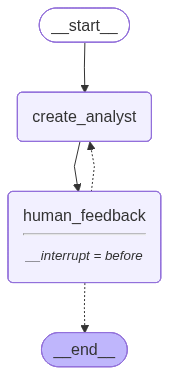

In [56]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [57]:
topic = "the benefits of adopting Langgraph as an agent framework"
max_analysts = 4
thread =  {"configurable":{"thread_id":1}}

In [58]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Chen focuses on the strategic benefits of adopting new technologies like Langgraph. She is particularly interested in how Langgraph can streamline processes and improve efficiency in various industries. Her motive is to identify technologies that can provide a competitive edge to businesses.
--------------------------------------------------
Name: Raj Patel
Affiliation: FutureTech Research Group

Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Chen focuses on the strategic benefits of adopting new technologies like Langgraph. She is particularly interested in how Langgraph can streamline processes and improve efficiency in various industries. Her motive is to identify technologies that can provide a competitive edge to businesses.
--------------------------------------------------
Name: Raj Patel
Affiliation: FutureTech Research Group
Role

In [59]:
state = graph.get_state(thread)

In [60]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Emily Chen', role='Technology Adoption Specialist', affiliation='Tech Innovators Inc.', description='Dr. Chen focuses on the strategic benefits of adopting new technologies like Langgraph. She is particularly interested in how Langgraph can streamline processes and improve efficiency in various industries. Her motive is to identify technologies that can provide a competitive edge to businesses.'), Analyst(name='Raj Patel', role='AI Framework Analyst', affiliation='FutureTech Research Group', description='Raj Patel analyzes different AI frameworks and their impact on development processes. He is concerned with the flexibility and scalability of Langgraph as an agent framework, and how it compares to other frameworks in terms of ease of integration and performance.'), Analyst(name='Sophia Martinez', role='Business Process Consultant', affiliation='G

In [61]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'analysts': [Analyst(name='Dr. Emily Chen', role='Technology Adoption Specialist', affiliation='Tech Innovators Inc.', description='Dr. Chen focuses on the strategic benefits of adopting new technologies like Langgraph. She is particularly interested in how Langgraph can streamline processes and improve efficiency in various industries. Her motive is to identify technologies that can provide a competitive edge to businesses.'),
  Analyst(name='Raj Patel', role='AI Framework Analyst', affiliation='FutureTech Research Group', description='Raj Patel analyzes different AI frameworks and their impact on development processes. He is concerned with the flexibility and scalability of Langgraph as an agent framework, and how it compares to other frameworks in terms of ease of integration and performance.'),
  Analyst(name='Sophia Martinez', role='Business Process Consultant', affiliation='Global Solutions

In [62]:

state.next

('human_feedback',)

In [63]:
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0aae9f-3109-6c1c-bfff-4b467a8dbd68': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-16T23:43:43.053929+00:00\xa2id\xd9$1f0aae9f-3109-6c1c-bfff-4b467a8dbd68\xb0channel_versions\x81\xa9__start__\xd9400000000000000000000000000000001.0.09886794216755856\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0aae9f-310c-636b-8000-fc4bffd7a0c7': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-16T23:43:43.054935+00:00\xa2id\xd9$1f0aae9f-310c-636b-8000-fc4bffd7a0c7\xb0channel_versions\x84\xa9__start__\xd9400000000000000000000000000000002.0.07639650891392036\xa5topic\xd9400000000000000000000000000000002.0.07639650891392036\xacmax_analysts\xd9400000000000000000000000000000002.0.07639650891392036\xb8branch:to:create_analyst\xd9400000000000000000000000000000002.0.07639650891392036\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start

In [ ]:
# import msgpack

# for thread_id, ns_dict in memory.storage.items():
#     print(f"\n Thread ID: {thread_id}")
    
#     # ns_dict = defaultdict(dict, {'': {...}})
#     for ns, ckpts in ns_dict.items():
#         print(f"  Namespace: '{ns}'")
        
#         # ckpts = dict of {checkpoint_id: (packed_values, packed_metadata, parent_id)}
#         for ckpt_id, (packed_values, packed_metadata, parent_id) in ckpts.items():
#             print(f"    Checkpoint ID: {ckpt_id}")
            
#             # Decode msgpack binary
#             values = msgpack.unpackb(packed_values[1], raw=False)
#             meta = msgpack.unpackb(packed_metadata[1], raw=False)
            
#             print(f"    Values keys: {list(values.keys())}")
#             print(f"    Parent ID: {parent_id}")
#             print(f"    Metadata: {meta}")
#             print("-" * 80)

In [64]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0aae9f-578c-6dbf-8001-b0f25fd5439b'}}

In [67]:
graph.update_state(thread,
                   {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0aaea5-b93f-6fd7-8002-c1e75b887fc6'}}

In [68]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Chen
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Chen focuses on the strategic benefits of adopting new technologies like Langgraph. She is particularly interested in how Langgraph can streamline processes and improve efficiency in various industries. Her motive is to identify technologies that can provide a competitive edge to businesses.
--------------------------------------------------
Name: Raj Patel
Affiliation: FutureTech Research Group
Role: AI Framework Analyst
Description: Raj Patel analyzes different AI frameworks and their impact on development processes. He is concerned with the flexibility and scalability of Langgraph as an agent framework, and how it compares to other frameworks in terms of ease of integration and performance.
--------------------------------------------------
Name: Sophia Martinez
Affiliation: Global Solutions Ltd.
Role: Business Process Consultant
Description: Sophia Martinez examines how Lang

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Sophia Tran
Affiliation: Tech Innovators Network
Role: Startup Ecosystem Analyst
Description: Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for startups. Her analysis often includes case studies of early-stage companies that have successfully integrated Langgraph into their workflows.
--------------------------------------------------
Name: Michael Chen
Affiliation: Global Enterprise Solutions
Role: Enterprise Application Specialist
Affiliation: Tech Innovators Network
Role: Startup Ecosystem Analyst
Description: Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for startups. Her analysis often includes case studies of early-stage companies that have s

In [69]:
state = graph.get_state(thread)

In [70]:

state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for startups. Her analysis often includes case studies of early-stage companies that have successfully integrated Langgraph into their workflows.'), Analyst(name='Michael Chen', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description='Michael specializes in the latest enterprise applications and how they can be optimized using frameworks like Langgraph. He examines how large organizati

In [71]:

state.next

('human_feedback',)